In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

In [131]:
def plot_results(result_dict):
    fig, ax = plt.subplots(figsize=(4, 3))

    dataset = result_dict["dataset"]
    task_type = result_dict["task_type"]

    ax.set_xlabel("Noise Level")
    perf_string = "RMSE" if task_type == "regression" else "ROC-AUC"
    ax.set_ylabel(perf_string)
    
    # ax.set_title(dataset)

    strucs = result_dict["structure"]
    feats = result_dict["feature"]
    ts = list(strucs.keys())

    # Ensure the x-axis values are numeric and sorted
    ts = sorted([float(t) for t in ts])  # Convert keys to floats and sort them

    struc_means = [np.mean([float(val) for val in strucs[str(t)]]) for t in ts]
    struc_devs = [np.std([float(val) for val in strucs[str(t)]]) for t in ts]
    feat_means = [np.mean([float(val) for val in feats[str(t)]]) for t in ts]
    feat_devs = [np.std([float(val) for val in feats[str(t)]]) for t in ts]

    ax.errorbar(ts, struc_means, yerr=struc_devs, label="Structure", c = "black")
    ax.errorbar(ts, feat_means, yerr=feat_devs, label="Feature", c = "blue", linestyle = "dashed")

    # Format x-axis ticks
    ax.set_xticks(ts)  # Ensure all unique noise levels are shown
    ax.set_xticklabels([f"{t:.1f}" for t in ts])  # Format as two decimal places

    ax.legend()
    plt.tight_layout()
    plt.savefig(f"figures/{dataset}.png", dpi=600)


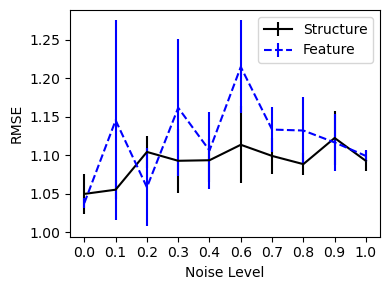

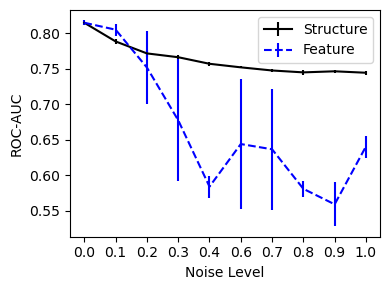

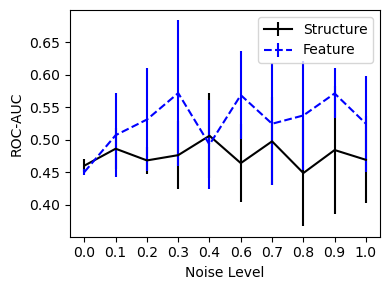

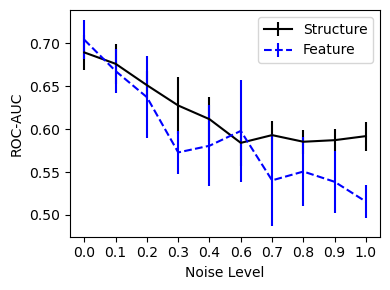

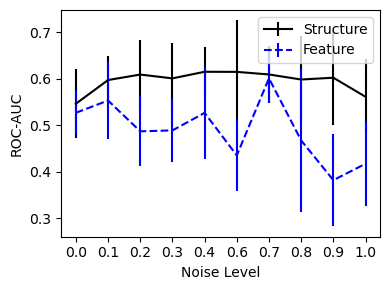

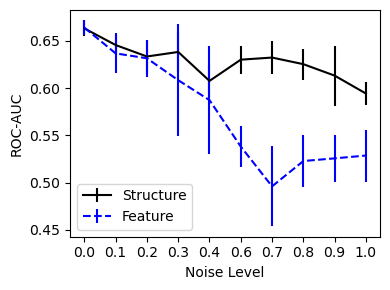

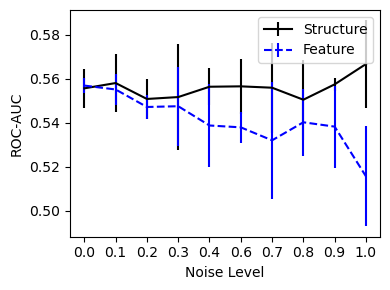

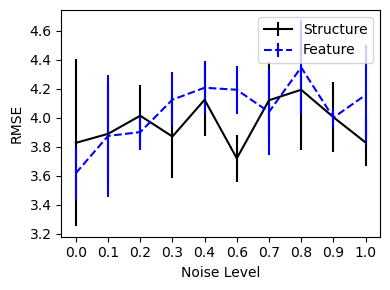

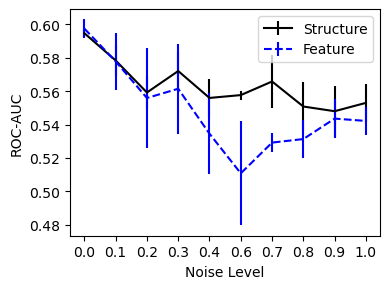

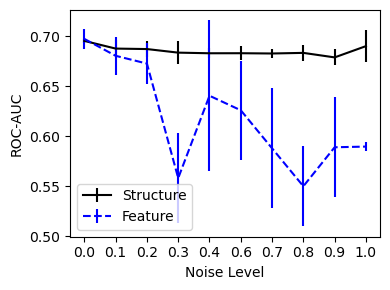

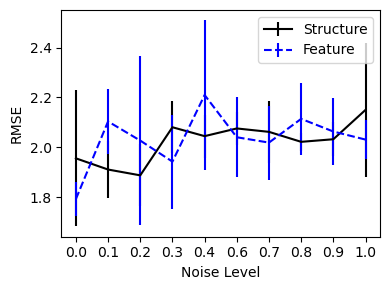

In [132]:
results_jsons = os.listdir("results")
result_dicts = []
for result in results_jsons:
    with open(f"results/{result}", "r") as f:
        dic = json.load(f)
    result_dicts.append(dic)

for result in result_dicts:
    plot_results(result)

In [133]:
from scipy.stats import spearmanr

def nncr(result_dict):
    dataset = result_dict["dataset"]
    strucs = result_dict["structure"]
    feats = result_dict["feature"]
    ts = list(strucs.keys())
    struc_means = [np.mean([float(val) for val in strucs[str(t)]]) for t in ts]
    struc_devs = [np.std([float(val) for val in strucs[str(t)]]) for t in ts]
    feat_means = [np.mean([float(val) for val in feats[str(t)]]) for t in ts]
    feat_devs = [np.std([float(val) for val in feats[str(t)]]) for t in ts]

    r_structure = np.abs(spearmanr(ts, struc_means)[0])
    r_feature = np.abs(spearmanr(ts, feat_means)[0])
    
    nncr = r_feature  / r_structure

    # print(f"r feature: {r_feature}\n r structure: {r_structure} nncr: {nncr}")

    return np.log10(nncr)

# for result in result_dicts:
#     print(result["dataset"])
#     print(nncr(result))

In [134]:
def nnd(result_dict):
    dataset = result_dict["dataset"]
    task = result_dict["task_type"]
    strucs = result_dict["structure"]
    feats = result_dict["feature"]
    ts = list(strucs.keys())
    struc_means = [np.mean([float(val) for val in strucs[str(t)]]) for t in ts]
    struc_devs = [np.std([float(val) for val in strucs[str(t)]]) for t in ts]
    feat_means = [np.mean([float(val) for val in feats[str(t)]]) for t in ts]
    feat_devs = [np.std([float(val) for val in feats[str(t)]]) for t in ts]
    if task == "classification":
        difference = np.array(feat_means) / np.mean(struc_means)
    else:
        difference = np.mean(struc_means) / np.array(feat_means)

    return np.log(np.sum(difference) / difference.shape[0])

def minmax_performance_structure(result_dict):
    dataset = result_dict["dataset"]
    task = result_dict["task_type"]
    strucs = result_dict["structure"]
    ts = list(strucs.keys())
    struc_means = [np.mean([float(val) for val in strucs[str(t)]]) for t in ts]

    # if task == "classification":
    return struc_means[0], struc_means[-1] # np.min(struc_means), np.max(struc_means)
    # else:
        # return np.max(struc_means), np.min(struc_means)

def minmax_performance_feature(result_dict):
    dataset = result_dict["dataset"]
    task = result_dict["task_type"]
    feats = result_dict["feature"]
    ts = list(feats.keys())
    feat_means = [np.mean([float(val) for val in feats[str(t)]]) for t in ts]

    # if task == "classification":
    return feat_means[0], feat_means[-1] # np.min(feat_means), np.max(feat_means)
    # else:
        # return np.max(feat_means), np.min(feat_means)

for result in result_dicts:
    print(result["dataset"])
    print(result["task_type"])
    print(f"nnd: {nnd(result)}")
    
    # print(f"nncr: {nncr(result)}")
    worse_structure, best_structure = minmax_performance_structure(result)
    print(worse_structure, best_structure)
    print(100 * np.abs(best_structure - worse_structure) / worse_structure)
    worse_feature, best_feature = minmax_performance_feature(result)
    print(worse_feature, best_feature)
    print(100 * np.abs(best_feature - worse_feature) / worse_feature)
    print("\n")

ogbg-mollipo
regression
nnd: -0.02473996116047969
1.04951724 1.092377
4.083759500701487
1.03770314 1.0988558000000002
5.893078438598545


ogbg-molpcba
classification
nnd: -0.13107584176721251
0.8144646839765756 0.744211946488271
8.625633360221304
0.8144875883478904 0.6405219271218084
21.358908805345273


ogbg-molclintox
classification
nnd: 0.10327587285904631
0.460323913470008 0.46926603319826776
1.94257119097993
0.450447971493163 0.5248080657544144
16.508031774404394


ogbg-molhiv
classification
nnd: -0.04816795606862696
0.6891576532793549 0.5917888194741536
14.128673365502348
0.703883641577403 0.5155263436237048
26.75972090097017


ogbg-molbace
classification
nnd: -0.19774898859599183
0.546215470847011 0.5611514928206158
2.7344560472524932
0.5267412518702128 0.4172377794153771
20.788854502289293


ogbg-molbbbp
classification
nnd: -0.0905808440683897
0.6631680575284091 0.5942116477272728
10.398029431353061
0.6640247691761363 0.5285955255681818
20.39520962086749


ogbg-molsider
classif

/opt/anaconda3/envs/intro_pyg/lib/python3.11/site-packages/ogb/graphproppred/dataset.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_dict = torch.load(pre_proces

[0.0, 0.02153846153846154, 0.04307692307692308, 0.06461538461538463, 0.08615384615384616, 0.1076923076923077, 0.12923076923076926, 0.1507692307692308, 0.17230769230769233, 0.19384615384615386, 0.2153846153846154, 0.23692307692307696, 0.2584615384615385, 0.28] 0.0
tensor([ 0.,  1.,  1.,  2.,  1.,  3.,  3.,  4.,  4.,  5.,  5.,  6.,  6.,  7.,
         7.,  8.,  8.,  9.,  9., 10., 10., 11., 11., 12., 12., 13., 13., 14.,
        14., 15., 15., 16., 16., 17., 17., 18., 18., 19., 19., 20., 12.,  3.,
        20., 15.,  9.,  4., 20., 11.])
[0.0, 0.02153846153846154, 0.04307692307692308, 0.06461538461538463, 0.08615384615384616, 0.1076923076923077, 0.12923076923076926, 0.1507692307692308, 0.17230769230769233, 0.19384615384615386, 0.2153846153846154, 0.23692307692307696, 0.2584615384615385, 0.28] 0.02153846153846154
tensor([ 0.,  1.,  1.,  2.,  1.,  3.,  3.,  4.,  4.,  5.,  5.,  6.,  6.,  7.,
         7.,  8.,  8.,  9.,  9., 10., 10., 11., 11., 12., 12., 13., 13., 14.,
        14., 15., 15., 16.,

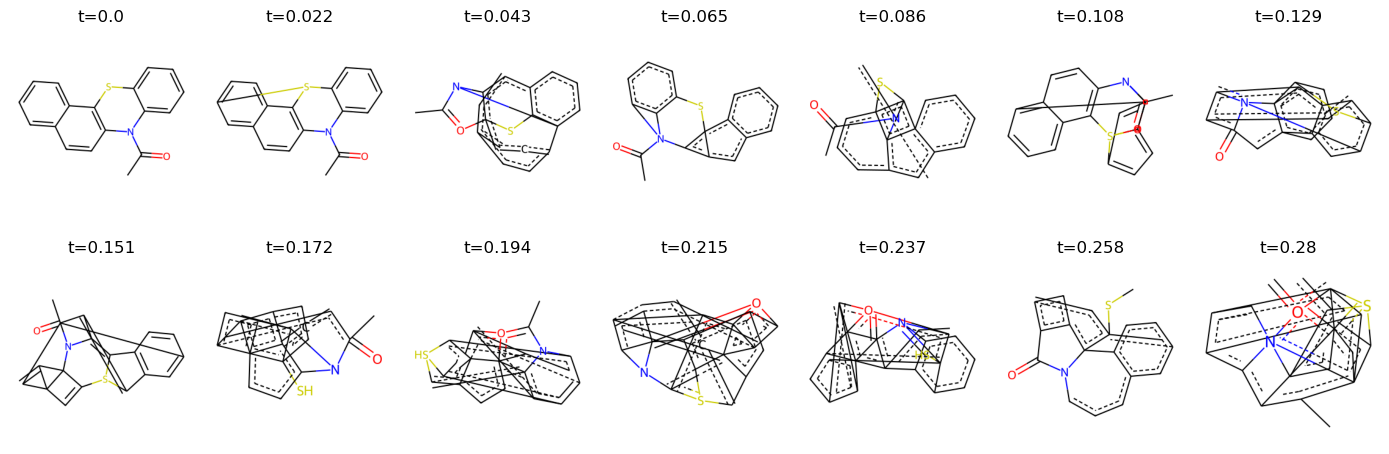

In [135]:
from noisenoise import add_noise_to_graph, add_noise_to_dataset
from ogb.graphproppred import GraphPropPredDataset
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch import Tensor
import numpy as np

# Load the dataset
dataset_name = "ogbg-molhiv"  # Change to desired OGB dataset
dataset = GraphPropPredDataset(name=dataset_name)

# Load the first few molecules from the dataset
num_molecules = 100  # Number of molecules to visualize
graphs, labels = zip(*[dataset[i] for i in range(num_molecules)])
graphs = [graphs[2]] * 14
num_molecules = 14

ts = np.linspace(0, 0.28, num_molecules).tolist()

for ig, g in enumerate(graphs):
    g2 = Data(
        x=Tensor(g["node_feat"]),
        edge_index=Tensor(g["edge_index"]),
        edge_attr=Tensor(g["edge_feat"])
    )
    print(ts, ts[ig])
    g = add_noise_to_graph(g2, t_structure=ts[ig], t_feature=0)
    graphs[ig] = g

# Visualize molecules
mols = []
for graph in graphs:
    # Convert OGB graph to RDKit molecule
    atom_features = graph.x  # Node features from the graph
    bonds = [
        (int(edge[0]), int(edge[1]), int(edge_attr[0]))
        for edge, edge_attr in zip(graph.edge_index.T, graph.edge_attr)
    ]
    mol = Chem.RWMol()
    
    # Add atoms using atomic numbers
    for atom_feature in atom_features:
        atomic_number = int(atom_feature[0] + 1)  # First feature is the atomic number
        atom = Chem.Atom(atomic_number)
        mol.AddAtom(atom)
    
    # Add bonds with types
    for bond in bonds:
        if not mol.GetBondBetweenAtoms(bond[0], bond[1]) and bond[0] != bond[1]:  # Check if bond already exists
            print(bond)
            bond_type = Chem.BondType.SINGLE  # Default bond type
            if bond[2] == 0:  # Modify based on your dataset's encoding
                bond_type = Chem.BondType.SINGLE
            elif bond[2] == 1:
                bond_type = Chem.BondType.DOUBLE
            elif bond[2] == 2:
                bond_type = Chem.BondType.TRIPLE
            elif bond[2] == 3:
                bond_type = Chem.BondType.AROMATIC
            mol.AddBond(bond[0], bond[1], bond_type)
    
    mols.append(mol)

# Create matplotlib figure
fig, axes = plt.subplots(2, int(num_molecules / 2), figsize=(num_molecules, 5))
print(axes)
axes = list(axes[0]) + list(axes[1])

for i, mol in enumerate(mols):
    # Generate RDKit image for the molecule
    img = Draw.MolToImage(mol)
    
    # Display the image on a matplotlib axis
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"t={np.around(ts[i], decimals=3)}")

plt.tight_layout()
plt.savefig("figures/molecule_structure_noise.png")
plt.show()
